# Gradient-based solver for ridge regression

In this notebook, you will create a **gradient descent** solver for **ridge regression** and then compare it to the built-in solver in `sklearn.linear_model`.

## 1. Set up notebook and create data set

After loading in some standard packages, we create a synthetic data set consisting of data points `(x,y)`:
* `x`: 100-dimensional vector whose coordinates are independent draws from a standard normal (Gaussian) distribution
* `y`: response value given by `y = wx + e` where `w` is a target regression function and `e` is Gaussian noise

We will fix `w` to be the 100-dimensional vector whose first ten coordinates are exactly 1.0, and whose remaining coordinates are zero. Thus only the first ten coordinates of `x` are relevant to the regression task.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

The following procedure, **generate_data**, creates a data set of a specified number of points. It is invoked as follows:
* `trainx, trainy = generate_data(n)`

Here:
* `n` is the target number of points
* `trainx`: `nx100` array of data points
* `trainy`: array of `n` response values

In [2]:
def generate_data(n):
    d = 100
    w = np.zeros(d)
    for i in range(0,10):
        w[i] = 1.0
    #
    trainx = np.random.normal(size=(n,d))
    e = np.random.normal(size=(n))
    trainy = np.dot(trainx, w) + e
    #
    return trainx, trainy

## 2. Gradient descent solver for ridge regression

<font color="magenta">**For you to do:**</font> Define a procedure, **ridge_regression_GD**, that uses gradient descent to solve the ridge regression problem. It is invoked as follows:

* `w,b,losses = ridge_regression_GD(x,y,C)`

Here, the input consists of:
* training data `x,y`, where `x` and `y` are numpy arrays of dimension `n`-by-`d` and `n`, respectively (if there are `n` training points)
* regularization constant `C`

The function should find the `d`-dimensional vector `w` and offset `b` that minimize the ridge regression loss function (with regularization constant `C`), and return:
* `w` and `b`
* `losses`, an array containing the ridge regression loss at each iteration

<font color="magenta">Advice:</font> First figure out the derivative, which has a relatively simple form. Next, when implementing gradient descent, think carefully about two issues.

1. What is the step size?
2. When has the procedure converged?

Take the time to experiment with different ways of handling these.

In [47]:
def ridge_regression_GD(x,y,C):
    ### Put your code here
    
    # maximum number of iterations
    max_iter = 1000
    
    # step size
    eta = 1 / max_iter
    
    # minimum change in loss to end descent
    epsilon = 0.0001
    
    # losses
    losses = np.zeros(max_iter)
    
    # loss at w
    def loss(X, y, w, C):
        assert (w.shape[1] == 1), "Weight vector should be a column vector"
        assert (y.shape[1] == 1), "Response vector should be a column vector"
        assert (X.shape[0] == y.shape[0]), "X and y should be same height"
        
        L_w = (y - X.dot(w)).T.dot(y - X.dot(w)) + C*w.T.dot(w)
        return L_w
    
    # derivative of loss function at w
    def derivative(X, y, w, C):
        assert (w.shape[1] == 1), "Weight vector should be a column vector"
        assert (y.shape[1] == 1), "Response vector should be a column vector"
        assert (X.shape[0] == y.shape[0]), "X and y should be same height"

        dl_dw = (X.T.dot(X) + C*np.identity(X.shape[1])).dot(w) - X.T.dot(y)
        return dl_dw
    
    # set weight vectors
    w_current = np.zeros(x.shape[1] + 1).reshape(-1, 1) # d + 1 dimensions
    w_next = np.zeros_like(w_current).reshape(-1, 1)

    # add column of ones to X
    X = np.c_[np.ones(x.shape[0]), x]
    
    # reshape y
    y = y.reshape(-1, 1)
    
    # start descent
    starting_loss = loss(X, y, w_current, C)
    losses[0] = starting_loss
    last_loss_ind = -1
    
    for step_time in range(1, max_iter):
        w_next = w_current - eta * derivative(X, y, w_current, C)
        
        # calculate change in loss
        current_loss = loss(X, y, w_current, C)
        next_loss = loss(X, y, w_next, C)
        losses[step_time] = next_loss
        
        delta_loss = current_loss - next_loss
        if np.abs(delta_loss) < epsilon:
            last_loss_ind = step_time
            break
        
        w_current = w_next
            
    w = w_next[1:]
    b = w_next[0]
    losses = losses[:last_loss_ind+1]
    
    return w, b, losses

Let's try it out and print a graph of the loss values during the optimization process.

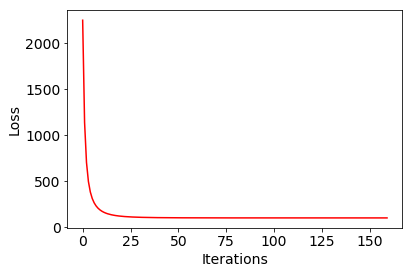

In [48]:
# Generate 200 data points
n = 200
x,y = generate_data(n)
# Set regularization constant
C = 1.0
# Run gradient descent solver
w, b, losses = ridge_regression_GD(x,y,C)
# Plot the losses
plt.plot(losses,'r')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.show()

<font color="magenta">**Something to think about**</font>

1. In setting the step size, does it work to use a fixed schedule 1/t? Why or why not?

2. Can you set up the gradient descent procedure in such a way that on each iteration, the loss monotonically decreases?


## 3. Evaluate the gradient descent solver

Now let's compare the regressor found by your gradient descent procedure to that returned by the built-in ridge regression solver in `sklearn`. We will compare them in two ways:
* Their MSE values
* The distance between the corresponding `w`-vectors

The latter should be smaller than 10^{-4}.


In [49]:
def compute_mse(w,b,x,y):
    residuals = y.reshape(-1,1) - (np.dot(x, w) + b)
    mse = residuals.T.dot(residuals)/n
    return mse[0,0]

In [50]:
# Generate 200 data points
n = 200
x,y = generate_data(n)
# Set regularization constant
C = 10.0
# Run gradient descent solver and compute its MSE
w, b, losses = ridge_regression_GD(x,y,C)
# Use built-in routine for ridge regression and compute MSE
regr = linear_model.Ridge(alpha=C)
regr.fit(x, y)
# Print MSE values and L2 distance between the regression functions
print ("MSE of gradient descent solver: ", compute_mse(w,b,x,y))
print ("MSE of built-in solver: ", mean_squared_error(regr.predict(x), y))
print ("Distance between w-coefficients: ", np.linalg.norm(w-regr.coef_.reshape(-1,1)))

MSE of gradient descent solver:  0.508383639025
MSE of built-in solver:  0.507856964639
Distance between w-coefficients:  0.00671065824035


<font color="magenta">**Something to think about**</font>

The data was originally generated using a linear function in which only ten of the 100 features (the first ten) were relevant. Does the vector `w` returned by ridge regression correctly identify the relevant features?

In [51]:
np.argsort(w.reshape(1,-1)[0])[::-1]

array([ 9,  4,  0,  5,  7,  1,  6,  8,  2,  3, 62, 81, 39, 72, 37, 59, 77,
       63, 71, 68, 18, 89, 14, 23, 30, 55, 64, 58, 51, 21, 87, 53, 99, 20,
       24, 35, 90, 43, 88, 85, 25, 52, 78, 38, 16, 76, 50, 82, 34, 91, 29,
       92, 47, 42, 13, 41, 32, 56, 57, 45, 73, 19, 66, 75, 36, 48, 98, 60,
       83, 27, 44, 54, 28, 93, 74, 79, 49, 94, 86, 96, 95, 12, 10, 40, 11,
       26, 61, 84, 22, 17, 97, 31, 33, 46, 15, 67, 69, 65, 80, 70])

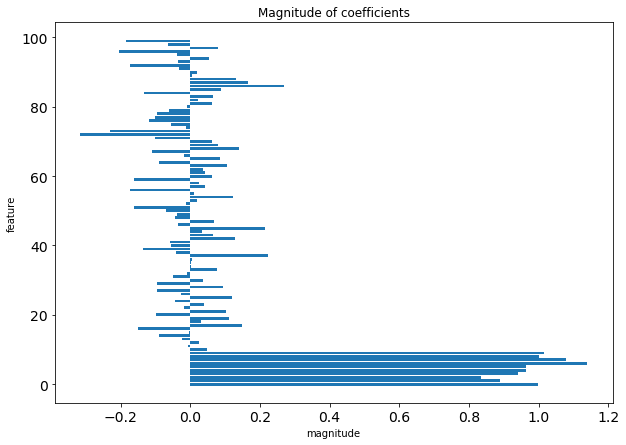

In [42]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.barh(range(len(w)), w, align='center')
ax.set(title="Magnitude of coefficients", xlabel="magnitude", ylabel="feature")

plt.show()